In [1]:
import pandas as pd
from analysis_helpers import load_url_data, analyze_authors_comprehensive, add_domain_column
import nest_asyncio

nest_asyncio.apply()


ALL_USERS = 'url_stream.csv'
LABELED_USERS = 'test_data.csv'

df = load_url_data(ALL_USERS)

def to_did(url):
    return url.split('/')[-1]

labeled = pd.read_csv(LABELED_USERS)
labeled['author'] = labeled['link'].apply(to_did)

df = add_domain_column(df)
author_stats = analyze_authors_comprehensive(df, labels_df=labeled)

test_data = author_stats[author_stats['label'].notnull()]

/home/cole/school/Trust-and-Safety/HW3/.venv/lib/python3.12/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning:

The 'default' attribute with value None was provided to the `Field()` function, which has no effect in the context it was used. 'default' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.



In [2]:
from analysis_helpers import populate_follower_count

test_data = populate_follower_count(test_data)

In [3]:
test_data.head()

,author,label,total_posts,unique_domains,unique_urls,first_post,last_post,top_domain,top_domain_count,domain_share,duration,duration_seconds,posts_per_minute,avg_time_between_posts,posts_to_bursty_urls,followers_count,follows_count,follower_following_ratio
0,did:plc:uld74vzf773y7ovqqm2jfaft,good,288,1,288,2025-11-21 00:43:36+00:00,2025-11-22 04:28:52+00:00,kripta.biz,288,1.000000,1 days 03:45:16,99916.000,0.172945,348.139373,0,111.0,0.1,1110.000000
1,did:plc:msian4dqa2rqalf3biilnf3m,good,285,1,237,2025-11-21 01:00:08+00:00,2025-11-22 04:01:07+00:00,europesays.com,285,1.000000,1 days 03:00:59,97259.000,0.175819,342.461268,0,2982.0,0.1,29820.000000
2,did:plc:ni6cl7jipinqldoyowqlbrwp,good,152,1,152,2025-11-21 01:30:05+00:00,2025-11-23 22:20:31+00:00,newsbeep.com,152,1.000000,2 days 20:50:26,247826.000,0.036800,1641.231788,0,106.0,6.0,17.666667
3,did:plc:uentzwq4lz5mkfa6ffu2lodl,good,80,1,80,2025-11-21 00:53:31.589000+00:00,2025-11-21 03:22:10.661000+00:00,youtube.com,80,1.000000,0 days 02:28:39.072000,8919.072,0.538169,112.899646,0,1179.0,331.0,3.561934
4,did:plc:btb6d463sylf5k5swmejfvl7,spam,59,2,53,2025-11-21 01:00:06+00:00,2025-11-22 03:54:04+00:00,amazon.com.br,46,0.779661,1 days 02:53:58,96838.000,0.036556,1669.620690,3,11.0,38.0,0.289474


In [4]:
target_column = 'label'
# feature_columns = ['unique_domains', 'unique_urls', 'avg_time_between_posts', 'followers_count', 'follows_count', 'follower_following_ratio']
feature_columns = ['unique_domains', 'unique_urls', 'followers_count', 'follows_count']

In [5]:
from analysis_helpers import augment_data

test_data = augment_data(test_data, feature_columns, target_column, num_synthetic_rows=150)

/home/cole/school/Trust-and-Safety/HW3/.venv/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning:

We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.



In [36]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
import numpy as np

# Quick normalization
scaler = StandardScaler()
test_data[feature_columns] = scaler.fit_transform(test_data[feature_columns])

# Prepare features and target
X = test_data[feature_columns]
y = test_data[target_column]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

classifier = DecisionTreeClassifier(
    random_state=42,
    max_depth=2,
    min_samples_split=5,
    min_samples_leaf=5,
    max_features='sqrt',
    class_weight='balanced'
)
classifier.fit(X_train, y_train)

# Method 1: Standard predictions
y_pred_standard = classifier.predict(X_test)

# Method 2: High-precision predictions using probability threshold
# Only predict positive class if probability > threshold
y_proba = classifier.predict_proba(X_test)

def report_at_threshold(threshold: float = 0.5):
    """Higher threshold -> higher precision"""

    # Get class labels
    classes = classifier.classes_
    spam_idx = list(classes).index('spam')  # Adjust based on your label names

    y_pred_high_precision = np.where(y_proba[:, spam_idx] >= threshold, 'spam', 'good')
    
    precision = precision_score(y_test, y_pred_high_precision, pos_label='spam', zero_division=1)
    
    recall = recall_score(y_test, y_pred_high_precision, pos_label='spam', zero_division=1)

    return precision, recall

In [37]:
prec, rec = report_at_threshold(threshold=0.9)

In [38]:
prec

1.0

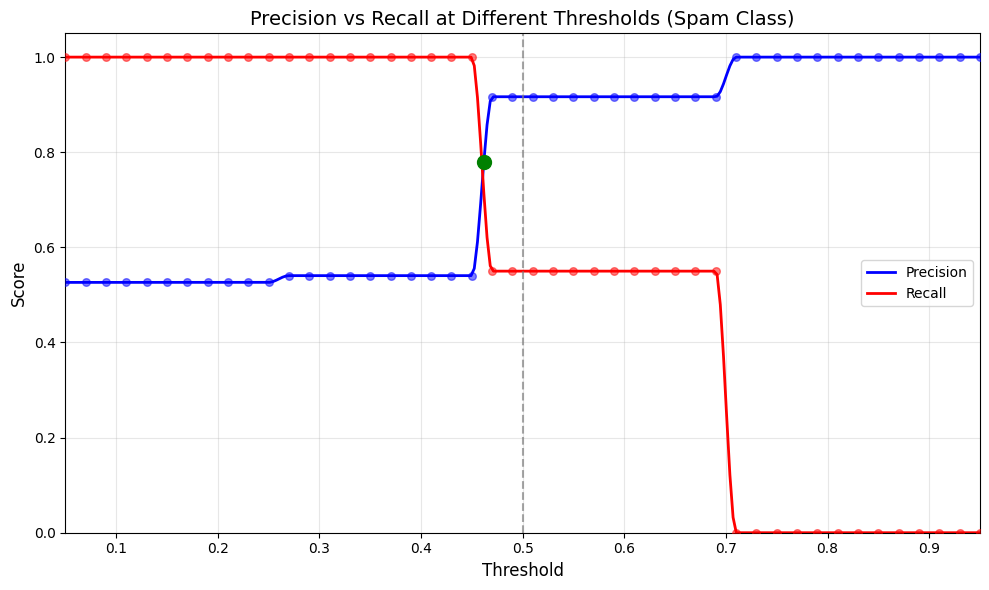

In [40]:
## Plot precision/recall for 'spam' label at different thresholds
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score
from scipy.interpolate import PchipInterpolator

# Get class labels
classes = classifier.classes_
spam_idx = list(classes).index('spam')

# Test different thresholds (more granular)
thresholds = np.arange(0.05, 1.0, 0.02)
precisions = []
recalls = []

for threshold in thresholds:
    y_pred_thresh = np.where(y_proba[:, spam_idx] >= threshold, 'spam', 'good')
    
    precision, recall = report_at_threshold(threshold)
    
    precisions.append(precision)
    recalls.append(recall)

precisions = np.array(precisions)
recalls = np.array(recalls)

# Use PCHIP interpolation (monotonic, no overshoot)
thresholds_smooth = np.linspace(thresholds.min(), thresholds.max(), 300)

precision_interp = PchipInterpolator(thresholds, precisions)
recall_interp = PchipInterpolator(thresholds, recalls)

precisions_smooth = precision_interp(thresholds_smooth)
recalls_smooth = recall_interp(thresholds_smooth)

# Clip values to valid range [0, 1]
precisions_smooth = np.clip(precisions_smooth, 0, 1)
recalls_smooth = np.clip(recalls_smooth, 0, 1)

# Plot precision and recall vs threshold
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(thresholds_smooth, precisions_smooth, 'b-', linewidth=2, label='Precision')
ax1.plot(thresholds_smooth, recalls_smooth, 'r-', linewidth=2, label='Recall')

# Add original points as markers
ax1.scatter(thresholds, precisions, color='blue', s=30, alpha=0.5, zorder=5)
ax1.scatter(thresholds, recalls, color='red', s=30, alpha=0.5, zorder=5)

ax1.set_xlabel('Threshold', fontsize=12)
ax1.set_ylabel('Score', fontsize=12)
ax1.set_title('Precision vs Recall at Different Thresholds (Spam Class)', fontsize=14)
ax1.legend(loc='center right')
ax1.grid(True, alpha=0.3)
ax1.set_xlim(0.05, 0.95)
ax1.set_ylim(0, 1.05)

# Mark default threshold (0.5)
ax1.axvline(x=0.5, color='gray', linestyle='--', alpha=0.7, label='Default (0.5)')

# Find and mark the threshold where precision = recall (F1 optimal point)
diff = np.abs(precisions_smooth - recalls_smooth)
optimal_idx = np.argmin(diff)
ax1.scatter([thresholds_smooth[optimal_idx]], [precisions_smooth[optimal_idx]], 
            color='green', s=100, zorder=5, label=f'P=R @ {thresholds_smooth[optimal_idx]:.2f}')

plt.tight_layout()
plt.show()

## Quick digression for logistic comparison

In [8]:
from sklearn.metrics import accuracy_score, f1_score

## Logistic Regression Model
from sklearn.linear_model import LogisticRegression

lr_classifier = LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000)
lr_classifier.fit(X_train, y_train)
y_pred_lr = lr_classifier.predict(X_test)

print("=== Logistic Regression ===")
print(classification_report(y_test, y_pred_lr))

print("\n=== Decision Tree (for comparison) ===")
print(classification_report(y_test, y_pred_standard))

comparison = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision (spam)', 'Precision (good)', 'F1 (spam)', 'F1 (good)'],
    'Decision Tree': [
        accuracy_score(y_test, y_pred_standard),
        precision_score(y_test, y_pred_standard, pos_label='spam', zero_division=0),
        precision_score(y_test, y_pred_standard, pos_label='good', zero_division=0),
        f1_score(y_test, y_pred_standard, pos_label='spam', zero_division=0),
        f1_score(y_test, y_pred_standard, pos_label='good', zero_division=0)
    ],
    'Logistic Regression': [
        accuracy_score(y_test, y_pred_lr),
        precision_score(y_test, y_pred_lr, pos_label='spam', zero_division=0),
        precision_score(y_test, y_pred_lr, pos_label='good', zero_division=0),
        f1_score(y_test, y_pred_lr, pos_label='spam', zero_division=0),
        f1_score(y_test, y_pred_lr, pos_label='good', zero_division=0)
    ]
})

print("\n=== Model Comparison ===")
print(comparison.to_string(index=False))

=== Logistic Regression ===
              precision    recall  f1-score   support

        good       1.00      0.35      0.52        20
        spam       0.61      1.00      0.75        20

    accuracy                           0.68        40
   macro avg       0.80      0.68      0.64        40
weighted avg       0.80      0.68      0.64        40


=== Decision Tree (for comparison) ===
              precision    recall  f1-score   support

        good       0.68      0.95      0.79        20
        spam       0.92      0.55      0.69        20

    accuracy                           0.75        40
   macro avg       0.80      0.75      0.74        40
weighted avg       0.80      0.75      0.74        40


=== Model Comparison ===
          Metric  Decision Tree  Logistic Regression
        Accuracy       0.750000             0.675000
Precision (spam)       0.916667             0.606061
Precision (good)       0.678571             1.000000
       F1 (spam)       0.687500         

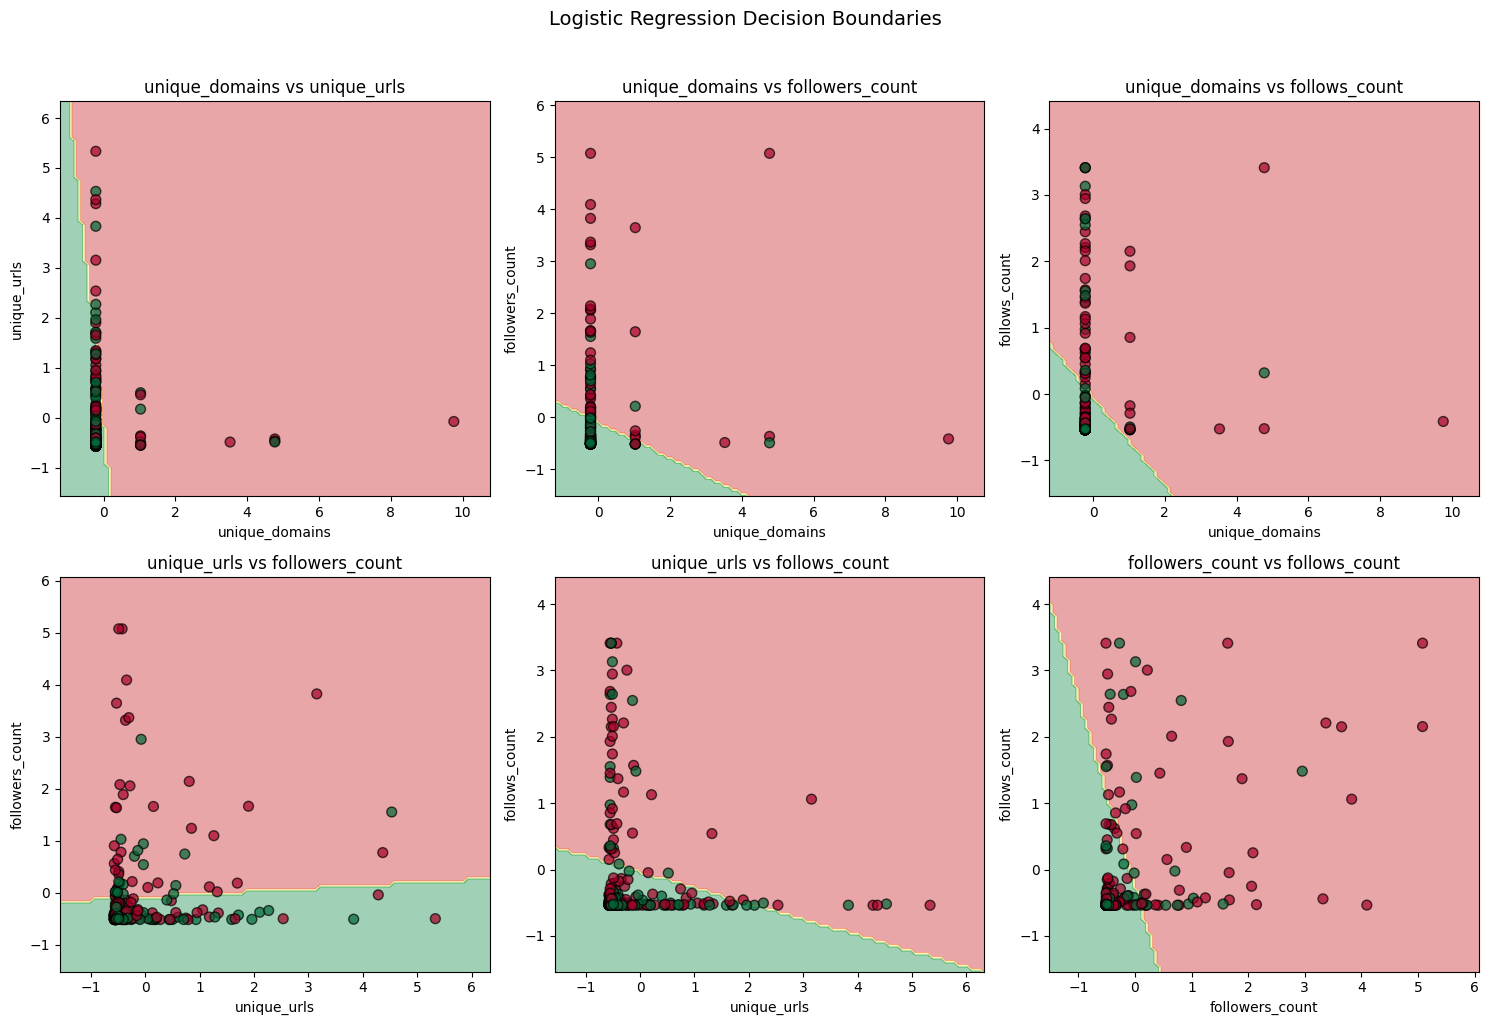

In [9]:
# Plot decision boundaries for Logistic Regression
import matplotlib.pyplot as plt
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.preprocessing import LabelEncoder
from itertools import combinations

# Encode labels to numeric values
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Get all pairwise combinations of features
feature_pairs = list(combinations(range(len(feature_columns)), 2))

n_plots = len(feature_pairs)
n_cols = 3
n_rows = (n_plots + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten() if n_plots > 1 else [axes]

for idx, (i, j) in enumerate(feature_pairs):
    X_pair = X.iloc[:, [i, j]].values
    
    # Train logistic regression on this feature pair
    lr_pair = LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000)
    lr_pair.fit(X_pair, y_encoded)
    
    # Create mesh grid
    feature_1, feature_2 = np.meshgrid(
        np.linspace(X_pair[:, 0].min() - 1, X_pair[:, 0].max() + 1, 100),
        np.linspace(X_pair[:, 1].min() - 1, X_pair[:, 1].max() + 1, 100)
    )
    grid = np.vstack([feature_1.ravel(), feature_2.ravel()]).T
    y_grid = lr_pair.predict(grid).reshape(feature_1.shape)
    
    # Plot decision boundary
    display = DecisionBoundaryDisplay(xx0=feature_1, xx1=feature_2, response=y_grid)
    display.plot(ax=axes[idx], alpha=0.4, cmap='RdYlGn')
    
    # Scatter actual points
    scatter = axes[idx].scatter(X_pair[:, 0], X_pair[:, 1], c=y_encoded, 
                                 cmap='RdYlGn', edgecolor='black', s=50, alpha=0.7)
    
    axes[idx].set_xlabel(feature_columns[i])
    axes[idx].set_ylabel(feature_columns[j])
    axes[idx].set_title(f'{feature_columns[i]} vs {feature_columns[j]}')

# Remove extra subplots
for idx in range(n_plots, len(axes)):
    fig.delaxes(axes[idx])

fig.suptitle('Logistic Regression Decision Boundaries', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## Report scores

In [41]:
# Report feature importance
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': classifier.feature_importances_
}).sort_values('importance', ascending=False)

print("Feature Importance Rankings:")
print("="*50)
for _, row in feature_importance.iterrows():
    print(f"{row['feature']}: {row['importance']:.4f}")

Feature Importance Rankings:
followers_count: 0.5189
follows_count: 0.4258
unique_urls: 0.0553
unique_domains: 0.0000


In [ ]:
from sklearn.tree import export_graphviz
import graphviz

# Export tree to DOT format
dot_data = export_graphviz(
    classifier,
    feature_names=feature_columns,
    class_names=['Not Spam', 'Spam'],
    filled=True,
    rounded=True,
    impurity=False,
    proportion=True,
    special_characters=True
)

# Replace default colors with custom colors (blue for Not Spam, orange for Spam)
# Class 0 (Not Spam) -> blue, Class 1 (Spam) -> orange
dot_data = dot_data.replace('fillcolor="#', 'fillcolor="#temp')

# Create custom color mapping based on class
lines = dot_data.split('\n')
new_lines = []
for line in lines:
    if 'class = Not Spam' in line or "value = [1.0, 0.0]" in line:
        line = line.replace('fillcolor="#temp', 'fillcolor="#3498db')
    elif 'class = Spam' in line:
        line = line.replace('fillcolor="#temp', 'fillcolor="#e67e22')
    new_lines.append(line)

dot_data = '\n'.join(new_lines)

# Display the tree
graph = graphviz.Source(dot_data)
graph